In [9]:
from SimPEG import EM
import numpy as np
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
from pymatsolver import PardisoSolver
from SimPEG.EM.Static import DC
import SimPEG.EM.Static.Utils as StaticUtils
#import EMTD.Utils as EMIPUtils
import pickle
from ipywidgets import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Button', 'Widget', 'var', 'interactive', 'Text', 'dtype']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def uniqueRows(M):
    b = np.ascontiguousarray(M).view(np.dtype((np.void, M.dtype.itemsize * M.shape[1])))
    unqInd = np.unique(b, return_index=True)
    invInd = np.unique(b, return_inverse=True)
    unqM = M[unqInd]
    return unqM, unqInd, invInd

In [3]:
stype = 'dipole-dipole'
dtype = 'appConductivity'

# Survey parameters
b = 20 # Tx-Rx seperation
a = 20 # Dipole spacing
n = 15  # Number of Rx per Tx

# Model parameters (background, sphere1, sphere2)
sig = np.r_[1e-2,1e-1,1e-3]

# Centroid of spheres
#loc = np.c_[[-75.,0.,-75.],[75.,0.,-75.]]
loc = np.c_[[-75.,0.,-75.],[75.,0.,-75.]]

# Radius of spheres
radi = np.r_[50.,50.]

# Forward solver
slvr = 'BiCGStab' #'LU'

# Preconditioner
pcdr = 'Jacobi'#

# Inversion parameter
pct = 0.02 # Percent of abs(obs) value
flr = 2e-5 # Minimum floor value
chifact = 100
ref_mod = ([1e-2,1e-1])

# DOI threshold
cutoff = 0.8

# number of padding cells
padc = 0

# Plotting param
xmin, xmax = -250, 250
ymin, ymax = -150, 150
zmin, zmax = -125, 25
vmin = -2.4771213
vmax = -1.4771213
depth = 200. # Maximum depth to plot
dx_in = 5

#`srvy_end = [(-200.  ,  0.), (200.  ,  0.)]
srvy_end = [(-225.  ,  0.), (225.  ,  0.)]
#%% SCRIPT STARTS HERE
nx = int(np.abs(srvy_end[0][0] - srvy_end[1][0]) /dx_in * 1.25)
ny = nx#int( np.max(radi) /dx_in ) 
ny += (ny+1)%2 # Make sure it is odd so the survey is centered

nz = int( np.abs( np.min(loc[2,:]) - np.max(radi) )  /dx_in )

# Create mesh
hxind = [(dx_in,15,-1.3), (dx_in, nx), (dx_in,15,1.3)]
hyind = [(dx_in,15,-1.3), (dx_in, int(ny/3)), (dx_in,15,1.3)]
hzind = [(dx_in,13,-1.3),(dx_in, nz)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCN')

mesh2D = Mesh.TensorMesh([hxind, hzind], 'CN')

In [4]:

# Set background conductivity
model = np.ones(mesh.nC) * sig[0]

## SPHERE MODEL
## First anomaly
#ind = Utils.ModelBuilder.getIndicesSphere(loc[:,0],radi[0],mesh.gridCC)
#model[ind] = sig[1]
#
## Second anomaly
#ind = Utils.ModelBuilder.getIndicesSphere(loc[:,1],radi[1],mesh.gridCC)
#model[ind] = sig[2]
#
## Create blocs for pole-dipole
#ind = Utils.ModelBuilder.getIndicesBlock(([-150.,-50.,-20]),([-130.,50.,0]),mesh.gridCC)
#model[ind] = sig[1]/2.5
##
#ind = Utils.ModelBuilder.getIndicesBlock(([-20.,-50.,-20]),([0.,50.,0]),mesh.gridCC)
#model[ind] = sig[2]
##
#ind = Utils.ModelBuilder.getIndicesBlock(([125.,-50.,-20]),([145,50.,0]),mesh.gridCC)
#model[ind] = sig[1]/5

## BLOCK MODEL
# Create blocs for gradient plot
ind = Utils.ModelBuilder.getIndicesBlock(([-25.,-25.,-75]),([25.,25.,-20]),mesh.gridCC)
model[ind] = sig[1]

ind = Utils.ModelBuilder.getIndicesBlock(([-150.,-10.,-25]),([-130.,10.,0]),mesh.gridCC)
model[ind] = sig[1]/2.5
#
ind = Utils.ModelBuilder.getIndicesBlock(([-70.,-10.,-25]),([-50.,10.,0]),mesh.gridCC)
model[ind] = sig[2]
#
ind = Utils.ModelBuilder.getIndicesBlock(([110.,-10.,-25]),([130.,10.,0]),mesh.gridCC)
model[ind] = sig[1]/5.

ind = Utils.ModelBuilder.getIndicesBlock(([-140.,-100.,-25]),([-120.,-80.,0]),mesh.gridCC)
model[ind] = sig[1]/2.5
#
ind = Utils.ModelBuilder.getIndicesBlock(([-20.,-20.,-25]),([0.,0.,0]),mesh.gridCC)
model[ind] = sig[1]/2.5
#
ind = Utils.ModelBuilder.getIndicesBlock(([125.,100.,-25]),([145,120.,0]),mesh.gridCC)
model[ind] = sig[1]/5

ind = Utils.ModelBuilder.getIndicesBlock(([80.,-125.,-25]),([100,-105.,0]),mesh.gridCC)
model[ind] = sig[1]/2.5

ind = Utils.ModelBuilder.getIndicesBlock(([-110.,80.,-25]),([-90,100.,0]),mesh.gridCC)
model[ind] = sig[1]/2.5

In [15]:
nz = mesh.vectorNz
var = np.c_[np.asarray(srvy_end),np.ones(2).T*nz[-1]]

# Snap the endpoints to the grid. Easier to create 2D section.
indx = Utils.closestPoints(mesh, var )
endl = np.c_[mesh.gridCC[indx,0],mesh.gridCC[indx,1],np.ones(2).T*nz[-1]]

survey = StaticUtils.gen_DCIPsurvey(endl, mesh, stype, a, b, n)
#survey = DC.SurveyDC.Survey(srcList)

Tx = StaticUtils.getSrc_locs(survey)

dl_len = np.sqrt( np.sum((endl[0,:] - endl[1,:])**2) )
dl_x = ( Tx[-1][0] - Tx[0][0] ) / dl_len
dl_y = ( Tx[-1][1] - Tx[0][1]  ) / dl_len
azm =  np.arctan(dl_y/dl_x)

# Plot stations along line
if stype == 'gradient':
    Rx = survey.srcList[0].rxList[0].locs
    plt.scatter(Tx[0][0::3],Tx[0][1::3],s=40,c='r')
    plt.scatter(np.c_[Rx[0][:,0],Rx[1][:,0]],np.c_[Rx[0][:,1],Rx[1][:,1]],s=20,c='y')

#%% Forward model data
data = []#np.zeros( nstn*nrx )
unct = []

idenMap = Maps.IdentityMap(nP=mesh.nC)
problem = DC.Problem3D_CC(mesh, rhoMap=idenMap, Solver=Utils.SolverUtils.SolverBiCG, solverOpts={"tol":1e-5})

survey.pair(problem)

In [16]:
dobs = problem.fields(m=model)

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\scipy\sparse\linalg\isolve\iterative.py:186: RuntimeWarning: invalid value encountered in multiply
  work[slice2] *= sclr2


KeyboardInterrupt: 

In [15]:
# Depth weight
actind = np.ones(mesh2D.nC, dtype='bool')
mesh1D, topoCC = StaticUtils.gettopoCC(mesh2D, ~actind)
zCC = Utils.mkvc(np.repeat(topoCC.reshape([-1,1]), mesh2D.nCy, axis=1))
dz = mesh2D.hy.min()*0.5
depth_weight = 1./abs(mesh2D.gridCC[:,1]-zCC + dz)**1.5
depth_weight /= depth_weight.max()
depth_weight[~actind] = np.nan

In [5]:
# Make sure electrode is below topo
nElec = len(uniqElec[1])
for iElec in range (nElec):
    inds = uniqElec[2] == iElec    
    A[inds,2] = elec_topo[iElec,1] - csy0/2.
    B[inds,2] = elec_topo[iElec,1] - csy0/2.
    M[inds,2] = elec_topo[iElec,1] - csy0/2.
    N[inds,2] = elec_topo[iElec,1] - csy0/2.    

In [ ]:
mesh2D.plotImage(actind, grid=True, gridOpts={"color":"k", "alpha":0.2})
figsize(10, 2)
plt.plot(elec_topo[:,0], elec_topo[:,1],'k.')
plt.plot(pts[:,0], pts[:,1],'r.', ms=3)
plt.ylim(-30, 0)
plt.xlim(-240, 240)
# plt.gca().set_aspect("equal")

In [7]:
# Find unique source pair
uniq = EMIPUtils.uniqueRows(np.c_[A, B])
nSrc = len(uniq[1])

In [9]:
srcLists = []
appres = []

for iSrc in range (nSrc):
    inds = uniq[2] == iSrc    
    # TODO: y-location should be assigned ...

    locsM = M[inds,:]
    locsN = N[inds,:]    
    
    rx = DC.Rx.Dipole(locsM, locsN)
    
    locA = uniq[0][iSrc,:3]
    locB = uniq[0][iSrc,3:]    
    
    src = DC.Src.Dipole([rx], locA, locB)
    
    appres.append(dc2d_example["appRho"][inds])
    srcLists.append(src)
dobs_appres = np.hstack(appres)

In [10]:
DCsurvey = DC.Survey(srcLists)

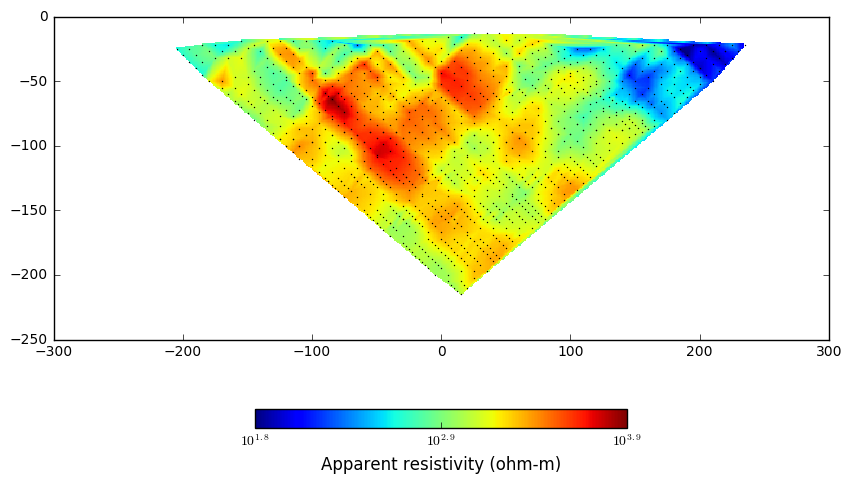

In [11]:
DCsurvey.dobs = dobs_appres
fig, ax = plt.subplots(1,1, figsize = (10,6))
dat = EM.Static.Utils.plot_pseudoSection(DCsurvey, ax, dataType='volt', surveyType="dipole-dipole", sameratio=True, scale="log")
cb = dat[2]
cb.set_label("Apparent resistivity (ohm-m)")
geometric = np.hstack(dat[3])
# Covert to voltage.. (we need explicit function, which does this...)
dobs_voltage = dobs_appres * geometric

In [12]:
srcLists2D = []
for iSrc in range (nSrc):
    src = srcLists[iSrc]
    locsM = np.c_[src.rxList[0].locs[0][:,0], src.rxList[0].locs[0][:,2]] 
    locsN = np.c_[src.rxList[0].locs[1][:,0], src.rxList[0].locs[1][:,2]] 
    rx = DC.Rx.Dipole_ky(locsM, locsN)
    locA = np.r_[src.loc[0][0], src.loc[0][2]]
    locB = np.r_[src.loc[1][0], src.loc[1][2]]
    src = DC.Src.Dipole([rx], locA, locB)
    srcLists2D.append(src)
DCsurvey2D = DC.Survey_ky(srcLists2D)

In [13]:
%%time
m0 = np.ones(actind.sum())*np.log(1e-3)
actMap = Maps.InjectActiveCells(mesh2D, actind, np.log(1e-8))
mapping = Maps.ExpMap(mesh2D) * actMap
problem = DC.Problem2D_N(mesh2D, sigmaMap=mapping)
problem.Solver = PardisoSolver
if DCsurvey2D.ispaired:
    DCsurvey2D.unpair()
problem.pair(DCsurvey2D)
pred = DCsurvey2D.dpred(m0)

CPU times: user 22.4 s, sys: 747 ms, total: 23.2 s
Wall time: 4.26 s


/home/seogi/anaconda2/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


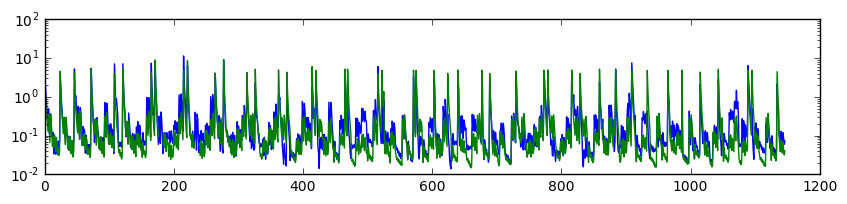

In [14]:
# This seems because of poor topo (?)
inds = abs(pred/geometric) > 3e3
pred[inds] = np.nan
plt.semilogy(abs(dobs_voltage) )
plt.semilogy(abs(pred) )

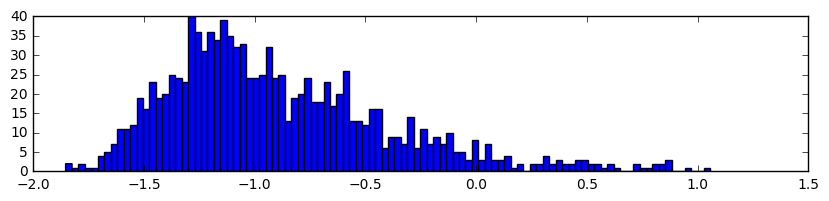

In [15]:
out = hist(np.log10(abs(dobs_voltage)), bins=100)

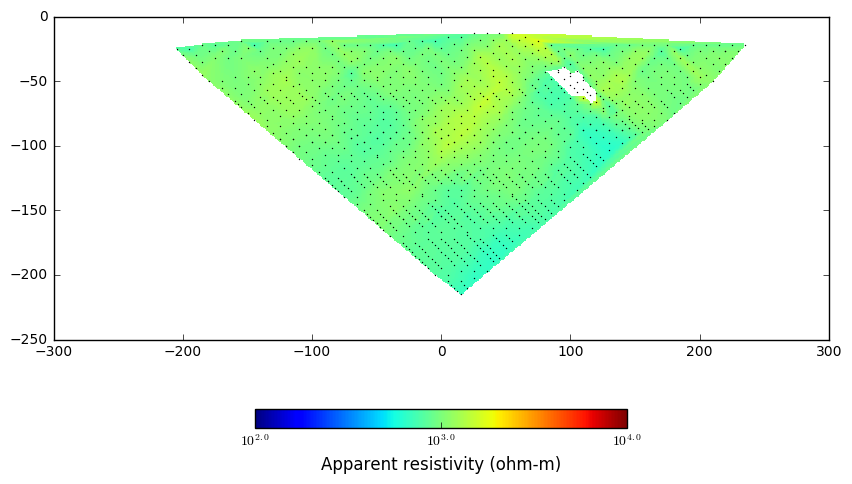

In [16]:
DCsurvey.dobs = pred
fig, ax = plt.subplots(1,1, figsize = (10,6))
dat = EM.Static.Utils.plot_pseudoSection(DCsurvey, ax, dataType='appResistivity', surveyType="dipole-dipole", scale="log",sameratio=True, clim=(2, 4))
cb = dat[2]
cb.set_label("Apparent resistivity (ohm-m)")

In [ ]:
%%time
DCsurvey2D.dobs = dobs_voltage
m0 = np.ones(actind.sum())*np.log(1e-3)
eps = 10**-1.8
std = 0.05
dmisfit = DataMisfit.l2_DataMisfit(DCsurvey2D)
uncert = abs(dobs_voltage) * std + eps
# Ignoring points where we have poor accuracy
uncert[inds] = np.Inf
dmisfit.Wd = 1./uncert
regmap = Maps.IdentityMap(nP=int(actind.sum()))
reg = Regularization.Simple(mesh2D, indActive=actind, mapping=regmap)
reg.cell_weights = depth_weight[actind]
opt = Optimization.InexactGaussNewton(maxIter=15)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
problem.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


In [ ]:
xc = opt.recall('xc')

In [ ]:
# sigma = mapping*mopt
iteration = 6
sigma = mapping*xc[iteration]
sigma[~actind] = np.nan
vmin = np.log10((1./sigma[actind]).min())
vmin = np.log10((1./sigma[actind]).max())
mesh2D.plotImage(np.log10(1./sigma), clim=(2, 4), grid=True, gridOpts={"color":"k", "alpha":0.1}, pcolorOpts={"cmap":"jet_r"})
figsize(10, 2)
plt.plot(elec_topo[:,0], elec_topo[:,1],'k.', ms=2.)
plt.ylim(-120, 0)
plt.xlim(-230, 230)
plt.gca().set_aspect("equal")

In [ ]:
coreinds = (mesh2D.gridCC[:,0]>-250) & (mesh2D.gridCC[:,0]<250) & (mesh2D.gridCC[:,1]>-120) & (mesh2D.gridCC[:,1]<0)
Utils.plot2Ddata(mesh2D.gridCC[coreinds], 1./sigma[coreinds], scale="log", ncontour=18, contourOpts={"vmin":2., "vmax":4, "cmap":"jet"})
plt.ylim(-100, 0)
plt.xlim(-250, 250)

In [ ]:
DCsurvey.dobs = invProb.dpred
fig, ax = plt.subplots(1,1, figsize = (10,6))
dat = EM.Static.Utils.plot_pseudoSection(DCsurvey, ax, dataType='appResistivity', surveyType="dipole-dipole", scale="log",sameratio=True, clim=(2, 4))
cb = dat[2]
cb.set_label("Apparent resistivity (ohm-m)")

In [ ]:
DCsurvey.dobs = dobs_voltage
fig, ax = plt.subplots(1,1, figsize = (10,6))
dat = EM.Static.Utils.plot_pseudoSection(DCsurvey, ax, dataType='appResistivity', surveyType="dipole-dipole", scale="log",sameratio=True, clim=(2, 4))
cb = dat[2]
cb.set_label("Apparent resistivity (ohm-m)")